# Introduction
## Using Google Search Volume and News Sentiment to Predict Natural Gas Prices with LSTMs
by Quinn Murphey, Adrian Ramos, and Gabriel Soliz

In [1]:
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import skopt as skopt
import skopt.plots
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Data Fetch Stage

## US EIA NYMEX Dataset
TODO EXPLAIN DATASET

In [2]:
# Read csvs to dataframes
nymex_spot_df = pd.read_csv("data/US_EIA_NYMEX_spot.csv")
nymex_futures_df = pd.read_csv("data/US_EIA_NYMEX_futures.csv")

# Turn Date column into a datetime object rather than string
nymex_spot_df["Date"] = nymex_spot_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))
nymex_futures_df["Date"] = nymex_futures_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))

# Trim to Jan 2013 - Jun 2019
nymex_spot_df = nymex_spot_df[(nymex_spot_df["Date"] >= datetime(year=2004, month=1, day=1)) & (nymex_spot_df["Date"] <= datetime(year=2019, month=6, day=28))]
nymex_futures_df = nymex_futures_df[(nymex_futures_df["Date"] >= datetime(year=2004, month=1, day=1)) & (nymex_futures_df["Date"] <= datetime(year=2019, month=6, day=28))]

# Reset index
nymex_spot_df = nymex_spot_df.set_index("Date")
nymex_futures_df = nymex_futures_df.set_index("Date")

# Rename Columns
nymex_spot_df    = nymex_spot_df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Spot Price'})
nymex_futures_df = nymex_futures_df.rename(columns={'Natural Gas Futures Contract 1 (Dollars per Million Btu)':'Futures 1 Price','Natural Gas Futures Contract 2 (Dollars per Million Btu)':'Futures 2 Price','Natural Gas Futures Contract 3 (Dollars per Million Btu)':'Futures 3 Price','Natural Gas Futures Contract 4 (Dollars per Million Btu)':'Futures 4 Price'})

In [3]:
nymex_spot_df

,Spot Price
Date,
2004-01-05,6.28
2004-01-06,7.04
2004-01-07,6.61
2004-01-08,6.41
2004-01-09,6.91
...,...
2019-06-24,2.31
2019-06-25,2.31
2019-06-26,2.34


In [4]:
nymex_futures_df

,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,
2004-01-05,6.827,6.630,5.580,5.380
2004-01-06,7.082,6.630,5.580,5.380
2004-01-07,6.878,6.693,5.673,5.383
2004-01-08,7.094,6.958,5.808,5.493
2004-01-09,7.287,7.193,5.903,5.563
...,...,...,...,...
2019-06-24,2.303,2.284,2.256,2.291
2019-06-25,2.308,2.286,2.260,2.294
2019-06-26,2.291,2.268,2.244,2.275


## Google Trends Dataset

### PyTrends Scraper

In [5]:
import pytrends
from pytrends.request import TrendReq
import time
pytrend = TrendReq()

def get_daily_trends_as_df(keywords, categories, timeframe, countries, search_type):
    # Get pytrend suggestions and store them in exact_keywords
    keywords_codes = [pytrend.suggestions(keyword=i)[0] for i in keywords] 
    df_CODES= pd.DataFrame(keywords_codes)
    exact_keywords = df_CODES['mid'].to_list()

    # Store keywords alongside their respective categories
    individual_exact_keyword = list(zip(*[iter(exact_keywords)]*1, categories))
    individual_exact_keyword = [list(x) for x in individual_exact_keyword]

    # Split timeframe into 1 month chunks
    timeframe_start, timeframe_end = timeframe.split(" ")
    start_date = date.fromisoformat(timeframe_start)
    end_date = date.fromisoformat(timeframe_end)
    dates = []
    while start_date < end_date:
        dates.append(start_date)
        start_date = start_date + relativedelta(months=6)
    dates.append(end_date + relativedelta(days=1))

    # Compute number of fetches required
    max_fetches = len(countries) * len(keywords) * (len(dates) - 1)
    curr_fetches = 0

    word_id = 0
    trend_dict = {}
    for country in countries:
        for keyword, category in individual_exact_keyword:
            try:
                trend_dict[keyword] = pd.read_csv(f"data/google_trends_series/{keywords[word_id]}.csv")
                trend_dict[keyword] = trend_dict[keyword].set_index("Date")
                curr_fetches += (len(dates) - 1)
                print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete!", end='\r')

            except:
                trend_dict[keyword] = pd.DataFrame()
                # Fetch overall google trends for normalizing
                pytrend.build_payload(kw_list=[keyword], 
                                        timeframe = timeframe, 
                                        geo = country, 
                                        cat=category,
                                        gprop=search_type)
                overall_data = pytrend.interest_over_time()
                time.sleep(5)
                month_num = 0
                for i in range(len(dates)-1):
                    pytrend.build_payload(kw_list=[keyword], 
                                        timeframe = dates[i].isoformat() + " " + (dates[i + 1] - relativedelta(days=1)).isoformat(), 
                                        geo = country, 
                                        cat=category,
                                        gprop=search_type)
                    curr_fetches += 1
                    print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                    print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete! [\"{keywords[word_id]}\" {dates[i]}-{dates[i+1] - relativedelta(days=1)}]", end='\r')
                    time.sleep(5) # sleep to prevent google shutting us down
                    month_data = pytrend.interest_over_time()

                    # normalize data based on overall_data
                    for month in range(0,6):
                        if month != 5:
                            indicies = month_data.index.intersection(pd.date_range(dates[i] + relativedelta(months=month), (dates[i] + relativedelta(months=month+1)) - relativedelta(days=1), freq='d'))
                        else:
                            indicies = month_data.index.intersection(pd.date_range(dates[i] + relativedelta(months=month), dates[i+1] - relativedelta(days=1), freq='d'))
                        month_data.loc[indicies] = month_data.loc[indicies] * (overall_data.iloc[month_num][keyword].mean() / month_data.loc[indicies].mean())
                        month_num += 1

                    # add data to trend_dict then delete for mem purposes
                    trend_dict[keyword] = pd.concat([trend_dict[keyword], month_data], axis=0)
                    del month_data
                del overall_data

                # fix up data and save partial data
                trend_dict[keyword] = trend_dict[keyword].drop('isPartial', axis=1)
                trend_dict[keyword] = trend_dict[keyword].reset_index(level=0)
                trend_dict[keyword] = trend_dict[keyword].rename(columns={'date': 'Date', keyword:keywords[word_id]})
                trend_dict[keyword] = trend_dict[keyword].set_index("Date")
                trend_dict[keyword].to_csv(f"data/google_trends_series/{keywords[word_id]}.csv")
            word_id+=1

    df_trends = pd.concat(trend_dict, axis=1)
    df_trends.columns = df_trends.columns.droplevel(0) #drop outside header

    return df_trends

In [6]:
KEYWORDS            = ["Natural Gas","Oil","Coal","Nuclear Power","Wind Power","Hydroelectric","Solar Power","Gold","Silver","Platinum","Copper","Biofuel","Recession","CPI"]
KEYWORDS_CATEGORIES = [904,          904,  904,   0,               0,          0,               0,           904,   904,     904,       904,     0,        0,          0]
TIMEFRAME='2004-01-01 2019-06-28' # Jan 2013 - June 2019
COUNTRIES=["US"] # ISO country code
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

try:
    google_trends_df = pd.read_csv("data/google_trends_dataset.csv")
    google_trends_df = google_trends_df.set_index("Date")
    google_trends_df.index = pd.to_datetime(google_trends_df.index)
except:
    google_trends_df = get_daily_trends_as_df(KEYWORDS, KEYWORDS_CATEGORIES, TIMEFRAME, COUNTRIES, SEARCH_TYPE)
    google_trends_df.index = pd.to_datetime(google_trends_df.index)
    google_trends_df.to_csv("data/google_trends_dataset.csv")

google_trends_df

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2004-01-01,149.131931,0.000000,NaN,3.379360,28.007722,0.000000,30.413514,27.125000,6.766147,0.000000,0.000000,0.000000,0.000000,23.105590
2004-01-02,62.474187,30.827298,NaN,11.151890,23.339768,0.000000,53.454054,23.906780,5.799555,0.000000,0.000000,0.000000,0.000000,67.391304
2004-01-03,0.000000,0.000000,NaN,11.489826,29.874903,42.747913,47.924324,26.205508,21.587231,0.000000,55.426934,0.000000,0.000000,75.093168
2004-01-04,0.000000,0.000000,NaN,14.193314,59.749807,125.190317,59.905405,30.343220,17.720861,0.000000,0.000000,0.000000,6.752475,61.614907
2004-01-05,0.000000,0.000000,NaN,18.586483,16.804633,97.709516,18.432432,5.516949,8.377134,0.000000,0.000000,0.000000,15.346535,28.881988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,15.734729,20.883978,0.0,9.605839,19.633466,12.923077,64.275796,50.068886,29.814815,40.695103,31.723598,24.830189,17.133144,23.886545
2019-06-25,18.471204,17.403315,0.0,8.992701,20.451527,10.769231,62.412729,55.694604,32.971678,35.387046,10.842243,12.943396,19.512748,29.038545
2019-06-26,17.787086,14.618785,0.0,8.379562,16.361222,4.307692,62.412729,48.943743,25.956427,39.810427,31.723598,8.716981,16.181303,28.101818


## Financial Times Scraper

# Data Visualization

## Plot Function

We will create a `plot` function that will be able to plot our data with, or without label and with or without predictions

In [7]:
def plot(data, units=None, feature_width=0, label_width=0, predictions=None, density=1, seperate=True, file=None, label_dates=[], labels=[]):
    """
    data: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted
    units: if seperate is True, a list of strings, else a string
    feature_width: input width of time series window
    label_width: label width of time series window
    predictions: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted (should match up with data column names)
    density: average every 'density' number of entries to end up plotting 1/density as many entries
    file: file to save figure to (None if no save)
    """
    # Verify units
    if units==None:
        units = [""] * len(data.columns)
    elif isinstance(units, str):
        units = [units] * len(data.columns)
    elif seperate and len(units) != len(data.columns):
        print("ERROR: Make sure units is the same length as data")
        return

    # Create new data if density != 1 using the mean of rolling windows
    if density != 1:
        # data
        data = data.rolling(density).mean().iloc[::density,:]

        # predictions
        if predictions is not None:
            predictions = predictions.rolling(density).mean().loc[data.index.intersection(predictions.index),:]

    # Create a 12x12 figure
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')

    # If plotting seperate Divide the fig into N subplots where N is the number of columns in data
    if seperate:
        ncols=math.ceil(math.sqrt(len(data.columns)))
        nrows=math.ceil( len(data.columns) / ncols)
    else: 
        plt.ylabel(units[0])
        plt.xlabel("Date")
    i = 1

    # Iterate over all columns in data
    for column, unit in zip(data.columns, units):
        # Label seperate subfigs
        if seperate:
            ax = plt.subplot(nrows,ncols,i)
            ax.set_title(column)
            plt.ylabel(unit)
            plt.xlabel('Date')
            plt.locator_params(axis='x', nbins=10)
        i+=1

        # Plot data
        plt.plot(data.index,data[column], label=column)

        # Plot labels
        if column in labels:
            plt.plot(data.loc[label_dates.intersection(data.index)][column], label=column + " labels" )

        # Plot predictions
        if feature_width != 0 and label_width != 0 and column in predictions.columns:
            # plot as one long series if label width is 1
            if label_width == 1:
                plt.plot(predictions.index, predictions[column], label=column + " Predictions")

            # plot as a lot of series if label width is > 1
            else:
                pass
            
        if seperate:
            plt.legend()

    if not seperate:
        plt.legend()
    plt.tight_layout()
    if file:
        plt.savefig(file)
    else:
        plt.show()

# Data Preprocessing Stage

## NYMEX

### Join dataframes (by date)

In [8]:
nymex_df = pd.concat([nymex_spot_df, nymex_futures_df],axis=1)
nymex_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2004-01-05,6.28,6.827,6.630,5.580,5.380
2004-01-06,7.04,7.082,6.630,5.580,5.380
2004-01-07,6.61,6.878,6.693,5.673,5.383
2004-01-08,6.41,7.094,6.958,5.808,5.493
2004-01-09,6.91,7.287,7.193,5.903,5.563
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


However, there are some NaN values due to the dates covered differing

In [9]:
nymex_df.isna().sum()

Spot Price         29
Futures 1 Price    33
Futures 2 Price    34
Futures 3 Price    34
Futures 4 Price    34
dtype: int64

### Fill spot price voids 
Interpolate all voids linearly (by column)

In [10]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Interpolate Weekends and Holidays

In [11]:
nymex_df = nymex_df.reindex(pd.date_range(nymex_df.index[0],nymex_df.index[-1],freq='d'))
nymex_df.index.names = ["Date"]
nymex_df


,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2004-01-05,6.28,6.827,6.630,5.580,5.380
2004-01-06,7.04,7.082,6.630,5.580,5.380
2004-01-07,6.61,6.878,6.693,5.673,5.383
2004-01-08,6.41,7.094,6.958,5.808,5.493
2004-01-09,6.91,7.287,7.193,5.903,5.563
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


In [12]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Plot NYMEX Data (note the exponential nature to it)

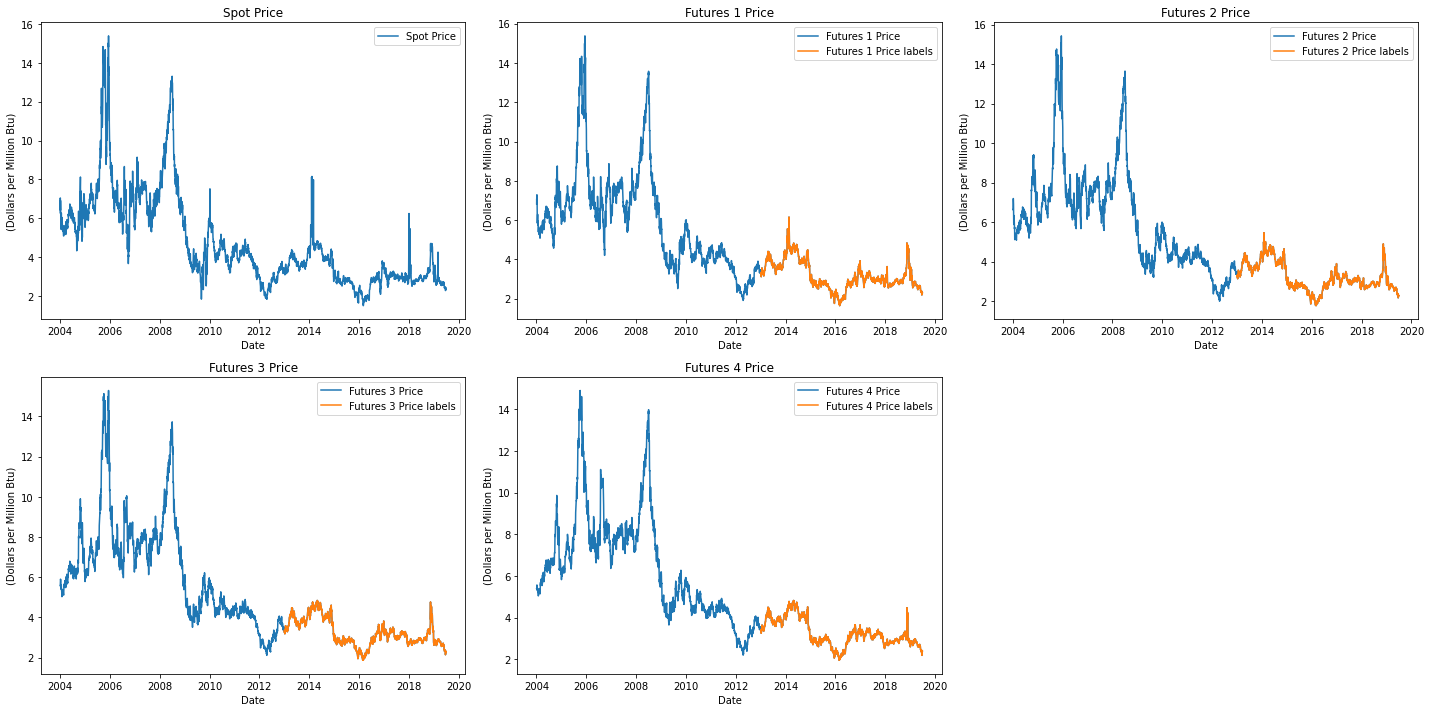

In [13]:
plot(
    nymex_df,
    units="(Dollars per Million Btu)", 
    seperate=True, 
    density=1, 
    file="images/nymex_data.png", 
    labels=nymex_df.columns[1:], 
    label_dates=pd.date_range(datetime(year=2013,month=1,day=1),datetime(year=2019,month=6,day=28),freq='d'))

### Normalize columns
First log all values: $x' = \log{x}$, then normalize: $x' = (x - \mu)/\sigma$

Check for negative values

In [14]:
means = {}
stds = {} 

def normalize_nymex(nymex_df):
    assert (nymex_df <= 0).sum().sum() == 0
    global means
    global stds

    nymex_df_normalized = np.log(nymex_df)
    for column in nymex_df_normalized.columns:
        means[column] = nymex_df_normalized[column].mean()
        stds[column] = nymex_df_normalized[column].std()
        nymex_df_normalized[column] = (nymex_df_normalized[column] - means[column]) / stds[column]
    
    return nymex_df_normalized

def restore_nymex(nymex_df_normalized):
    global means
    global stds

    for column in nymex_df_normalized:
        nymex_df_normalized[column] = nymex_df_normalized[column] * stds[column] + means[column]
    nymex_df = np.exp(nymex_df_normalized)
    return nymex_df

Log each value and Normalize each row

In [15]:
nymex_df_normalized = normalize_nymex(nymex_df)
nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2004-01-05,0.879004,1.032433,0.907849,0.472316,0.356587
2004-01-06,1.136008,1.114732,0.907849,0.472316,0.356587
2004-01-07,0.994220,1.049136,0.928988,0.509094,0.357830
2004-01-08,0.925099,1.118532,1.015779,0.561424,0.402903
2004-01-09,1.094076,1.178774,1.090022,0.597524,0.431119
...,...,...,...,...,...
2019-06-24,-1.370988,-1.406348,-1.474098,-1.542697,-1.545632
2019-06-25,-1.370988,-1.401481,-1.472142,-1.538755,-1.542716
2019-06-26,-1.341959,-1.418073,-1.489811,-1.554564,-1.561248


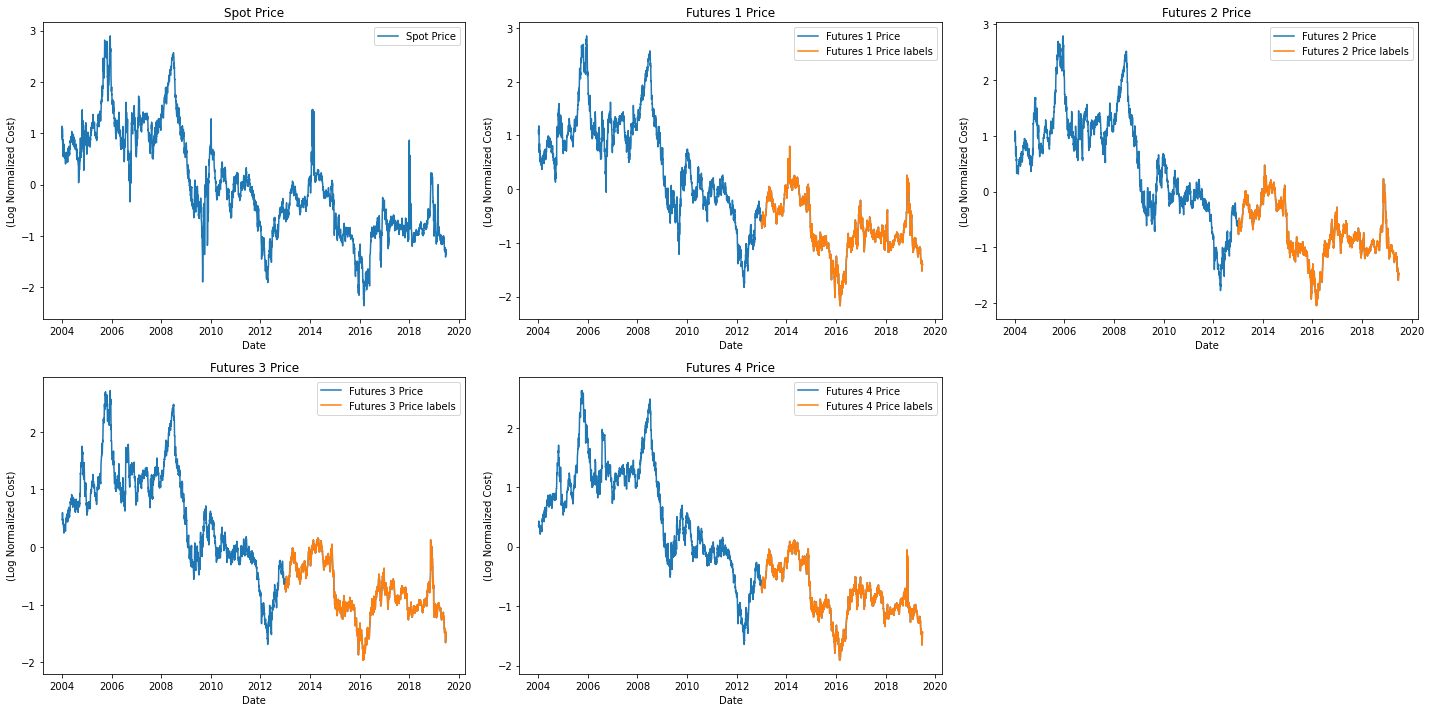

In [16]:
plot(
    nymex_df_normalized,
    units="(Log Normalized Cost)", 
    seperate=True, 
    density=1, 
    file="images/nymex_data_normalized.png", 
    labels=nymex_df.columns[1:], 
    label_dates=pd.date_range(datetime(year=2013,month=1,day=1),datetime(year=2019,month=6,day=28),freq='d'))

## Google Trends

### Plot Google Trends data

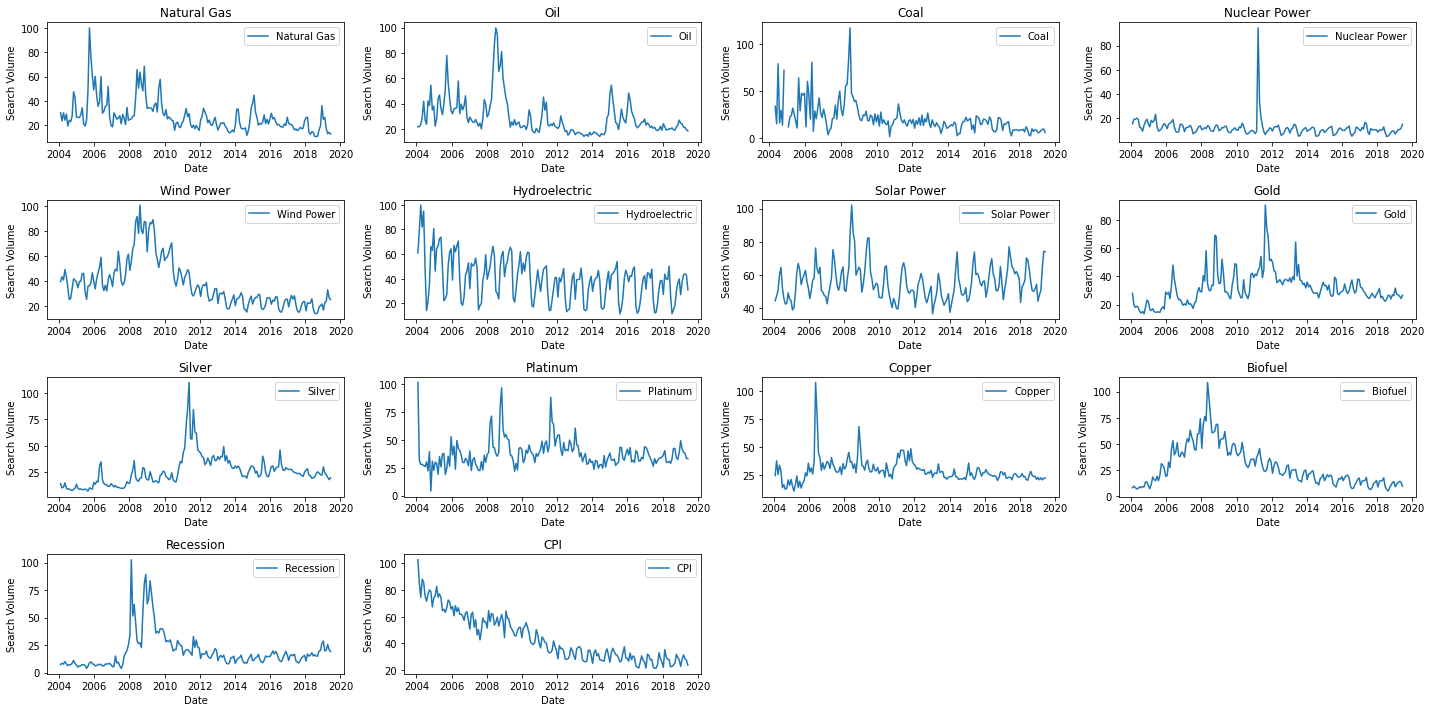

In [17]:
plot(google_trends_df,units="Search Volume", seperate=True, density=30, file="images/google_trends_data.png")

### Normalize Columns 
$x' = (x- \mu)/\sigma$

In [18]:
google_trends_df_normalized = google_trends_df.copy()

for column in google_trends_df_normalized.columns:
    google_trends_df_normalized[column] = (google_trends_df_normalized[column] - google_trends_df_normalized[column].mean()) / google_trends_df_normalized[column].std()

google_trends_df_normalized

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2004-01-01,4.725951,-1.454266,NaN,-0.723284,-0.437533,-1.364731,-1.860667,-0.323061,-1.161623,-1.062014,-1.482517,-1.238053,-1.034607,-0.830254
2004-01-02,1.369742,0.081832,NaN,-0.048210,-0.653965,-1.364731,-0.156766,-0.548741,-1.221847,-1.062014,-1.482517,-1.238053,-1.034607,0.936149
2004-01-03,-1.049851,-1.454266,NaN,-0.018859,-0.350960,0.098059,-0.565702,-0.387541,-0.238192,-1.062014,1.337812,-1.238053,-1.034607,1.243350
2004-01-04,-1.049851,-1.454266,NaN,0.215949,1.034206,2.919153,0.320326,-0.097381,-0.479087,-1.062014,-1.482517,-1.238053,-0.667986,0.705749
2004-01-05,-1.049851,-1.454266,NaN,0.597512,-0.956970,1.978788,-2.746695,-1.838342,-1.061250,-1.062014,-1.482517,-1.238053,-0.201376,-0.599854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,-0.440453,-0.413635,-0.353017,-0.182491,-0.825810,-0.922516,0.643527,1.285896,0.274430,0.096690,0.131698,-0.147386,-0.104373,-0.799105
2019-06-25,-0.334471,-0.587074,-0.353017,-0.235744,-0.787880,-0.996219,0.505749,1.680404,0.471119,-0.054445,-0.930823,-0.669514,0.024826,-0.593609
2019-06-26,-0.360966,-0.725824,-0.353017,-0.288997,-0.977529,-1.217326,0.505749,1.206994,0.034032,0.071501,0.131698,-0.855159,-0.156053,-0.630972


### Interpolate / Fill NaN

In [19]:
google_trends_df_normalized = google_trends_df_normalized.interpolate(method='time')
google_trends_df_normalized = google_trends_df_normalized.fillna(0)
google_trends_df_normalized.isna().sum()

Natural Gas      0
Oil              0
Coal             0
Nuclear Power    0
Wind Power       0
Hydroelectric    0
Solar Power      0
Gold             0
Silver           0
Platinum         0
Copper           0
Biofuel          0
Recession        0
CPI              0
dtype: int64

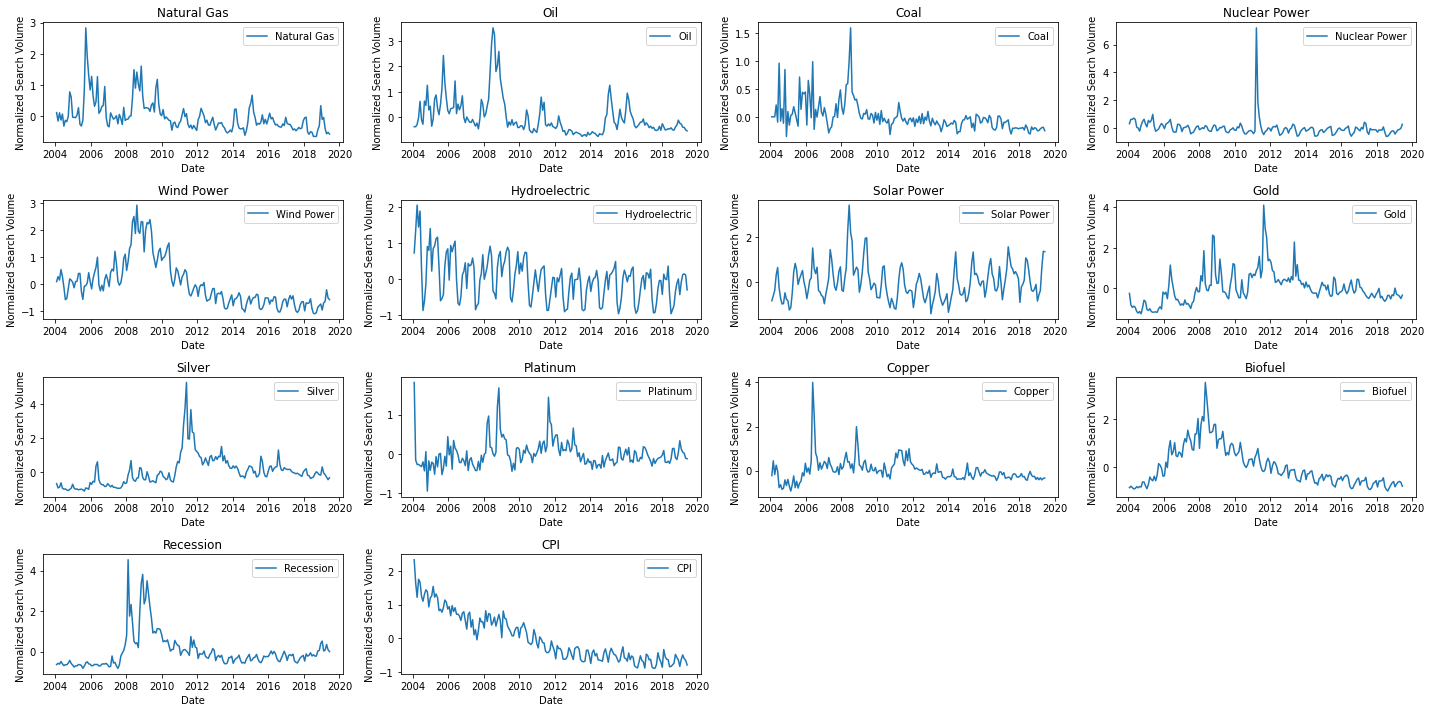

In [20]:
plot(google_trends_df_normalized,units="Normalized Search Volume", seperate=True, density=30, file="images/google_trends_data_normalized.png")

### Join individual dataframes into one dataframe

In [21]:
full_df = pd.concat([nymex_df_normalized, google_trends_df_normalized],axis=1).loc[nymex_df_normalized.index]
full_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,,,,,,
2004-01-05,0.879004,1.032433,0.907849,0.472316,0.356587,-1.049851,-1.454266,0.000000,0.597512,-0.956970,1.978788,-2.746695,-1.838342,-1.061250,-1.062014,-1.482517,-1.238053,-0.201376,-0.599854
2004-01-06,1.136008,1.114732,0.907849,0.472316,0.356587,1.447793,-0.641038,0.000000,0.744267,-0.047955,-1.364731,-1.928823,0.998779,0.424269,-1.062014,-1.482517,-0.273409,-0.434681,3.854555
2004-01-07,0.994220,1.049136,0.928988,0.509094,0.357830,-1.049851,-0.324782,0.000000,0.568161,1.293924,2.814668,-0.974638,0.450699,-1.442667,2.259119,-1.482517,-0.555744,-1.034607,3.086554
2004-01-08,0.925099,1.118532,1.015779,0.561424,0.402903,0.745331,0.307729,0.000000,1.155181,-0.307674,-0.528851,0.320326,-0.452021,-0.639684,-1.062014,3.507296,-0.532216,-0.817967,4.392156
2004-01-09,1.094076,1.178774,1.090022,0.597524,0.431119,-1.049851,-0.866934,0.000000,0.215949,-0.264387,0.411514,-0.156766,0.192779,-0.499162,-1.062014,1.880183,-0.532216,-0.584662,2.472152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,-1.370988,-1.406348,-1.474098,-1.542697,-1.545632,-0.440453,-0.413635,-0.353017,-0.182491,-0.825810,-0.922516,0.643527,1.285896,0.274430,0.096690,0.131698,-0.147386,-0.104373,-0.799105
2019-06-25,-1.370988,-1.401481,-1.472142,-1.538755,-1.542716,-0.334471,-0.587074,-0.353017,-0.235744,-0.787880,-0.996219,0.505749,1.680404,0.471119,-0.054445,-0.930823,-0.669514,0.024826,-0.593609
2019-06-26,-1.341959,-1.418073,-1.489811,-1.554564,-1.561248,-0.360966,-0.725824,-0.353017,-0.288997,-0.977529,-1.217326,0.505749,1.206994,0.034032,0.071501,0.131698,-0.855159,-0.156053,-0.630972


# Create Tensorflow Dataset

## Helper Functions

### Dataframe to Window Dataset function (batching compatible)

In [22]:
def window_df_to_ds(df, features, labels, feature_width=7, label_width=1, label_dates=None):
    """
    df : dataframe with a datetime index
    features : columns of df designated to be features
    labels : columns of df designmated to be labels
    feature_width : time-width of features in window
    label_width : time-width of labels in window
    label_dates : restrict the labels to come from this index
    """
    if label_dates is None:
        label_dates = df.index[feature_width:-(label_width)]

    def feature_gen():
        for label_start_date in label_dates:
            new_feature = df.loc[df.index.intersection(pd.date_range(label_start_date - relativedelta(days=feature_width), label_start_date - relativedelta(days=1), freq='d'))][features].values
            yield tf.convert_to_tensor(new_feature, dtype=np.float64)
    
    def label_gen():
        for label_start_date in label_dates:
            new_label = df.loc[df.index.intersection(pd.date_range(label_start_date, label_start_date + relativedelta(days=label_width - 1), freq='d'))][labels].values
            yield tf.convert_to_tensor(new_label, dtype=np.float64)

    # Turn np arrays into tf datasets
    feature_dataset = tf.data.Dataset.from_generator(feature_gen,
                                                     output_signature=(tf.TensorSpec(shape=(feature_width, len(features)), dtype=np.float64, name='Feature'))
                                                    )
    label_dataset = tf.data.Dataset.from_generator(label_gen,
                                                     output_signature=(tf.TensorSpec(shape=(label_width, len(labels)), dtype=np.float64, name='Label'))
                                                    )

    # Zip datasets together into feature, label pairs
    dataset = tf.data.Dataset.zip((feature_dataset, label_dataset))

    return dataset

### Dataframe to variable length input Dataset (batching not compatible)

In [23]:
def variable_df_to_ds(df, features, labels, label_width=1, label_dates=None):
    """
    df : dataframe with a datetime index
    features : columns of df designated to be features
    labels : columns of df designmated to be labels
    label_width : time-width of labels in window
    label_dates : restrict the labels to come from this index
    """
    if label_dates is None:
        label_dates = df.index[1:-(label_width)]

    start_date = df.index[0]
    end_date = df.index[-1]

    # Create feature generator
    def feature_gen():
        for label_start_date in label_dates:
            new_feature = df.loc[df.index.intersection(pd.date_range(start_date, label_start_date - relativedelta(days=1), freq='d'))][features].values
            yield tf.convert_to_tensor(new_feature, dtype=np.float64)

    def label_gen():
        for label_start_date in label_dates:
            new_label = df.loc[df.index.intersection(pd.date_range(label_start_date, label_start_date + relativedelta(days=label_width - 1), freq='d'))][labels].values
            yield tf.convert_to_tensor(new_label, dtype=np.float64)

    
    # Turn np arrays into tf datasets
    feature_dataset = tf.data.Dataset.from_generator(feature_gen,
                                                     output_signature=(tf.TensorSpec(shape=(None, len(features)), dtype=np.float64, name='Feature'))
                                                    )
    label_dataset = tf.data.Dataset.from_generator(label_gen,
                                                     output_signature=(tf.TensorSpec(shape=(label_width, len(labels)), dtype=np.float64, name='Label'))
                                                    )

    # Zip datasets together into feature, label pairs
    dataset = tf.data.Dataset.zip((feature_dataset, label_dataset))

    return dataset

### Dataframe to variable length input Dataset (batching compatible) 

In [24]:
def variable_batched_df_to_ds(df, features, labels, label_width=1, label_dates=None, batch_size=32):
    """
    df : dataframe with a datetime index
    features : columns of df designated to be features
    labels : columns of df designmated to be labels
    label_width : time-width of labels in window
    label_dates : restrict the labels to come from this index
    """
    if label_dates is None:
        label_dates = df.index[1:-(label_width)]

    start_date = df.index[0]
    end_date = df.index[-1]

    # Create feature generator
    def feature_gen():
        part_of_batch = 0
        for label_start_date in label_dates:
            new_feature = df.loc[df.index.intersection(pd.date_range(start_date + relativedelta(days=part_of_batch), label_start_date - relativedelta(days=1), freq='d'))][features].values
            yield tf.convert_to_tensor(new_feature, dtype=np.float64)
            part_of_batch = 0 if part_of_batch == 31 else part_of_batch+1

    def label_gen():
        for label_start_date in label_dates:
            new_label = df.loc[df.index.intersection(pd.date_range(label_start_date, label_start_date + relativedelta(days=label_width - 1), freq='d'))][labels].values
            yield tf.convert_to_tensor(new_label, dtype=np.float64)

    
    # Turn np arrays into tf datasets
    feature_dataset = tf.data.Dataset.from_generator(feature_gen,
                                                     output_signature=(tf.TensorSpec(shape=(None, len(features)), dtype=np.float64, name='Feature'))
                                                    )
    label_dataset = tf.data.Dataset.from_generator(label_gen,
                                                     output_signature=(tf.TensorSpec(shape=(label_width, len(labels)), dtype=np.float64, name='Label'))
                                                    )

    # Zip datasets together into feature, label pairs
    dataset = tf.data.Dataset.zip((feature_dataset, label_dataset))

    return dataset

### Train Validate Test Dataset Split Function

In [25]:
def train_val_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, batch_size=8, repeats=1, ds_size=None):
    """
    ds: tensorflow zip dataset
    train_split : 
    val_split :
    test_split :
    shuffle : whether to shuffle the ds or not
    """
    assert (train_split + val_split + test_split) == 1
    shuffle_size=10000

    # First batch
    ds = ds.batch(batch_size)

    # Then shuffle the batches
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=0)
    
    if ds_size is None:
        ds_size = len(ds)
    
    train_size = math.ceil(int(train_split * ds_size) / batch_size)
    val_size = math.ceil(int(val_split * ds_size) / batch_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

## Create Training, Validation, and Testing dataset

### Finalize Dataset

In [26]:
FEATURES = full_df.columns
LABELS = ['Futures 1 Price','Futures 2 Price','Futures 3 Price','Futures 4 Price']
FEATURE_WIDTH = 7
LABEL_WIDTH   = 1
TIMEFRAME = full_df.index
LABEL_DATES = pd.date_range(datetime(year=2013, month=1, day=1), datetime(year=2019, month=6, day=28))

TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1
TEST_SPLIT  = 0.1
BATCH_SIZE  = 16
REPEATS     = 1

#dataset = window_df_to_ds(full_df.loc[TIMEFRAME], features=FEATURES, labels=LABELS, feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, label_dates=LABEL_DATES)

dataset = variable_batched_df_to_ds(full_df.loc[TIMEFRAME], features=FEATURES, labels=LABELS, label_width=LABEL_WIDTH, label_dates=LABEL_DATES, batch_size=BATCH_SIZE)
train_ds, val_ds, test_ds = train_val_test_split(dataset, train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT, batch_size=BATCH_SIZE, repeats=REPEATS, ds_size=len(LABEL_DATES))

#dataset = variable_df_to_ds(full_df.loc[TIMEFRAME], features=FEATURES, labels=LABELS, label_width=LABEL_WIDTH, label_dates=LABEL_DATES)
#train_ds, val_ds, test_ds = train_val_test_split(dataset, train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT, batch_size=BATCH_SIZE, repeats=REPEATS, ds_size=len(LABEL_DATES))

In [27]:
for x,y in dataset.take(33):
    print(x.shape, y.shape)

(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3284, 19) (1, 4)
(3316, 19) (1, 4)


In [28]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 4), dtype=tf.float64, name=None))>

# Model Training Stage

## Helper Functions

### Model Creation Functions


#### Stacked LSTM Model
Parameters:
- num_lstm_layers: Number of stacked LSTM layers
- num_lstm_nodes: Number of LSTM nodes per LSTM layer
- num_dense_layers: Number of stacked Dense layers to follow the LSTM layers
- num_dense_nodes: Number of Dense nodes per Dense layer
- dropout_rate: Fraction of weights to cut randomly before each dense layer
- input_shape: Input Shape (without batching)
- output_shape: Output Shape (wihtout batching)
- learning_rate: Learning rate 

In [29]:
def create_stacked_lstm_model(num_lstm_layers, num_lstm_nodes, num_dense_layers, num_dense_nodes, dropout_rate, input_shape, output_shape, learning_rate):
    # Init model
    model = tf.keras.Sequential()

    # Add input layer
    model.add(tf.keras.layers.Input(shape=input_shape, name="Input"))

    # Add stacked LSTM layers
    for i in range(num_lstm_layers):
        if i < num_lstm_layers-1:
            model.add(tf.keras.layers.LSTM(units=num_lstm_nodes, input_shape=input_shape, return_sequences=True, name=f'LSTM_{i}'))
        else:
            model.add(tf.keras.layers.LSTM(units=num_lstm_nodes, input_shape=input_shape, return_sequences=False, name=f'LSTM_{i}'))

    # Add stacked dense layers
    for i in range(num_dense_layers):
        # Add dropout layer
        model.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f"Dropout_{i}"))
        # Add dense layer
        model.add(tf.keras.layers.Dense(units=num_dense_nodes, name=f"Dense_{i}"))

    # Add output layer + reshape
    model.add(tf.keras.layers.Dense(units=output_shape[0] * output_shape[1]))
    model.add(tf.keras.layers.Reshape(target_shape=output_shape))

    # Compile model
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])

    # Return model (pre-compiled)
    return model

#### Stacked BiLSTM Model
- num_lstm_layers: Number of stacked LSTM layers
- num_lstm_nodes: Number of LSTM nodes per LSTM layer
- num_dense_layers: Number of stacked Dense layers to follow the LSTM layers
- num_dense_nodes: Number of Dense nodes per Dense layer
- dropout_rate: Fraction of weights to cut randomly before each dense layer
- input_shape: Input Shape (without batching)
- output_shape: Output Shape (wihtout batching)
- learning_rate: Learning rate 

In [30]:
def create_stacked_bilstm_model(num_lstm_layers, num_lstm_nodes, num_dense_layers, num_dense_nodes, dropout_rate, input_shape, output_shape, learning_rate):
    # Init model
    model = tf.keras.Sequential()

    # Add input layer
    model.add(tf.keras.layers.Input(shape=input_shape, name="Input"))

    # Add stacked LSTM layers
    for i in range(num_lstm_layers):
        if i < num_lstm_layers-1:
            model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=num_lstm_nodes, input_shape=input_shape, return_sequences=True, name=f'LSTM_{i}')))
        else:
            model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=num_lstm_nodes, input_shape=input_shape, return_sequences=False, name=f'LSTM_{i}')))

    # Add stacked dense layers
    for i in range(num_dense_layers):
        # Add dropout layer
        model.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f"Dropout_{i}"))
        # Add dense layer
        model.add(tf.keras.layers.Dense(units=num_dense_nodes, name=f"Dense_{i}"))

    # Add output layer + reshape
    model.add(tf.keras.layers.Dense(units=output_shape[0] * output_shape[1]))
    model.add(tf.keras.layers.Reshape(target_shape=output_shape))

    # Compile model
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])

    # Return model (uncompiled)
    return model   

#### Ensemble Stacked BiLSTM Model

In [31]:
def create_ensemble_stacked_bilstm_model():
    # TODO Once models work
    pass

### Hyperparameter Evaluation Functions

In [32]:
search_num = 1
max_search = 50
MAX_EPOCHS = 5
INPUT_SHAPE = (None, len(FEATURES))
OUTPUT_SHAPE = (LABEL_WIDTH, len(LABELS))

SEARCH_STACKED_LSTM_HYPERPARAMS = True
SEARCH_STACKED_BILSTM_HYPERPARAMS = True
SEARCH_ENSEMBLE_STACKED_BILSTM_HYPERPARAMS = False

TRAIN_STACKED_LSTM_HYPERPARAMS = True
TRAIN_STACKED_BILSTM_HYPERPARAMS = True
TRAIN_ENSEMBLE_STACKED_BILSTM_HYPERPARAMS = False

#### Stacked LSTM Eval Function

In [33]:
lstm_dim_num_lstm_layers = skopt.space.Integer(low=1, high=5, name='num_lstm_layers')
lstm_dim_num_lstm_nodes = skopt.space.Integer(low=8, high=256, name='num_lstm_nodes')
lstm_dim_num_dense_layers = skopt.space.Integer(low=1, high=3, name='num_dense_layers')
lstm_dim_num_dense_nodes = skopt.space.Integer(low=32, high=2048, name='num_dense_nodes')
lstm_dim_dropout_rate = skopt.space.Real(low=0, high=1, prior='uniform', name='dropout_rate')
lstm_dim_learning_rate = skopt.space.Real(low=1e-6, high=1e-1, prior='log-uniform', name='learning_rate')

stacked_lstm_dimensions = [
    lstm_dim_num_lstm_layers,
    lstm_dim_num_lstm_nodes,
    lstm_dim_num_dense_layers,
    lstm_dim_num_dense_nodes,
    lstm_dim_dropout_rate,
    lstm_dim_learning_rate
]

###
# THE FOLLOWING FUNCTION WAS BASED OFF OF https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb
###

@skopt.utils.use_named_args(dimensions=stacked_lstm_dimensions)
def eval_stacked_lstm_hyperparams(num_lstm_layers, num_lstm_nodes, num_dense_layers, num_dense_nodes, dropout_rate, learning_rate):
    # Use current global variables for evaluation
    global train_ds
    global val_ds
    global MAX_EPOCHS
    global BATCH_SIZE
    global best_loss
    global INPUT_SHAPE
    global OUTPUT_SHAPE
    global search_num
    global max_search

    # Print current hyper-parameters
    print('Search Num', search_num, "/", max_search)
    print("-----------------------")
    print('num_lstm_layers:', num_lstm_layers)
    print('num_lstm_nodes:', num_lstm_nodes)
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('dropout_rate:', dropout_rate)
    print('learning_rate:{0:.1e}'.format(learning_rate))
    
    search_num += 1

    loss = np.inf
    try:
        # Create the model
        model = create_stacked_lstm_model(num_lstm_layers, num_lstm_nodes, num_dense_layers, num_dense_nodes, dropout_rate, INPUT_SHAPE, OUTPUT_SHAPE, learning_rate)

        # Define early_stopping to not overrun
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')

        # Train model
        history = model.fit(train_ds,
                            epochs=MAX_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=val_ds,
                            callbacks=[early_stopping],
                            verbose=0)

        # If loss is better than best loss, set best_loss to loss (and save the model)
        loss = history.history['val_loss'][-1]

        if loss < best_loss:
            model.save('models/stacked_lstm_best')
            best_loss = loss

        del model
    except:
        pass

    # Print loss
    print(f"\n|| val_loss: {loss} ||\n")

    # Clear the Keras session
    tf.keras.backend.clear_session()
    gc.collect()

    print()
    # Return loss for skopt to minimize
    return loss

#### Stacked BiLSTM Eval Function

In [34]:
bilstm_dim_num_bilstm_layers = skopt.space.Integer(low=1, high=5, name='num_bilstm_layers')
bilstm_dim_num_bilstm_nodes = skopt.space.Integer(low=8, high=128, name='num_bilstm_nodes')
bilstm_dim_num_dense_layers = skopt.space.Integer(low=1, high=3, name='num_dense_layers')
bilstm_dim_num_dense_nodes = skopt.space.Integer(low=32, high=2048, name='num_dense_nodes')
bilstm_dim_dropout_rate = skopt.space.Real(low=0, high=1, prior='uniform', name='dropout_rate')
bilstm_dim_learning_rate = skopt.space.Real(low=1e-6, high=1e-1, prior='log-uniform', name='learning_rate')

stacked_bilstm_dimensions = [
    bilstm_dim_num_bilstm_layers,
    bilstm_dim_num_bilstm_nodes,
    bilstm_dim_num_dense_layers,
    bilstm_dim_num_dense_nodes,
    bilstm_dim_dropout_rate,
    bilstm_dim_learning_rate
]

###
# THE FOLLOWING FUNCTION WAS BASED OFF OF https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb
###

@skopt.utils.use_named_args(dimensions=stacked_bilstm_dimensions)
def eval_stacked_bilstm_hyperparams(num_bilstm_layers, num_bilstm_nodes, num_dense_layers, num_dense_nodes, dropout_rate, learning_rate):
    # Use current global variables for evaluation
    global train_ds
    global val_ds
    global MAX_EPOCHS
    global BATCH_SIZE
    global best_loss
    global INPUT_SHAPE
    global OUTPUT_SHAPE
    global search_num
    global max_search

    # Print current hyper-parameters
    print('Search Num', search_num, "/", max_search)
    print("-----------------------")
    print('num_bilstm_layers:', num_bilstm_layers)
    print('num_bilstm_nodes:', num_bilstm_nodes)
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('dropout_rate:', dropout_rate)
    print('learning_rate:{0:.1e}'.format(learning_rate))
    
    search_num += 1

    loss = np.inf
    try:
        # Create the model
        model = create_stacked_bilstm_model(num_bilstm_layers, num_bilstm_nodes, num_dense_layers, num_dense_nodes, dropout_rate, INPUT_SHAPE, OUTPUT_SHAPE, learning_rate)

        # Define early_stopping to not overrun
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')

        # Train model
        history = model.fit(train_ds,
                            epochs=MAX_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=val_ds,
                            callbacks=[early_stopping],
                            verbose=0)

        # If loss is better than best loss, set best_loss to loss (and save the model)
        loss = history.history['val_loss'][-1]

        if loss < best_loss:
            model.save('models/stacked_bilstm_best')
            best_loss = loss

        del model
    except:
        pass

    # Print loss
    print(f"\n|| val_loss: {loss} ||\n")

    # Clear the Keras session
    tf.keras.backend.clear_session()
    gc.collect()

    print()
    # Return loss for skopt to minimize
    return loss

#### Ensemble Stacked BiLSTM Eval Function

### Reset Weights

In [35]:
def reset_weights(model):
    session = tf.keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)

## Baesian Hyperparameter Search

### Stacked LSTM

In [36]:
if SEARCH_STACKED_LSTM_HYPERPARAMS:
    try:
        model = tf.keras.models.load_model("models/stacked_lstm_best")
        best_loss = model.evaluate(val_ds, verbose=0)[0]
        print(f"Inital best_loss from saved model: {best_loss}")
    except:
        best_loss = np.inf
        print(f"Inital best_loss: {best_loss}")

    print("#########################")

    tf.keras.backend.clear_session()
    gc.collect()

    default_params = [1, 32, 1, 32, 0, 1e-3]
    search_num = 1
    search_result = skopt.gp_minimize(func=eval_stacked_lstm_hyperparams,
                                dimensions=stacked_lstm_dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=max_search,
                                x0=default_params)

Inital best_loss from saved model: 0.004688123241066933
#########################
Search Num 1 / 50
-----------------------
num_lstm_layers: 1
num_lstm_nodes: 32
num_dense_layers: 1
num_dense_nodes: 32
dropout_rate: 0
learning_rate:1.0e-03

|| val_loss: 0.021558132022619247 ||


Search Num 2 / 50
-----------------------
num_lstm_layers: 4
num_lstm_nodes: 180
num_dense_layers: 2
num_dense_nodes: 82
dropout_rate: 0.8547623691549449
learning_rate:3.2e-03

|| val_loss: inf ||


Search Num 3 / 50
-----------------------
num_lstm_layers: 3
num_lstm_nodes: 96
num_dense_layers: 2
num_dense_nodes: 1921
dropout_rate: 0.7928140223318654
learning_rate:1.9e-05


### Stacked BiLSTM

In [ ]:
if SEARCH_STACKED_BILSTM_HYPERPARAMS:
    try:
        model = tf.keras.models.load_model("models/stacked_bilstm_best")
        best_loss = model.evaluate(val_ds, verbose=0)[0]
        print(f"Inital best_loss from saved model: {best_loss}")
    except:
        best_loss = np.inf
        print(f"Inital best_loss: {best_loss}")

    print("#########################")

    tf.keras.backend.clear_session()
    gc.collect()

    default_params = [1, 32, 3, 64, 0, 1e-3]
    search_num = 1
    search_result = skopt.gp_minimize(func=eval_stacked_bilstm_hyperparams,
                                dimensions=stacked_bilstm_dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=max_search,
                                x0=default_params)

Inital best_loss: inf
#########################
Search Num 1 / 50
-----------------------
num_bilstm_layers: 5
num_bilstm_nodes: 128
num_dense_layers: 1
num_dense_nodes: 32
dropout_rate: 0
learning_rate:1.0e-03
Epoch 1/5
     45/Unknown - 54s 940ms/step - loss: 0.2307 - mean_absolute_error: 0.3617 - root_mean_squared_error: 0.4803
|| val_loss: inf ||


Search Num 2 / 50
-----------------------
num_bilstm_layers: 1
num_bilstm_nodes: 92
num_dense_layers: 3
num_dense_nodes: 1992
dropout_rate: 0.9764943970126776
learning_rate:8.6e-02
Epoch 1/5
     18/Unknown - 11s 219ms/step - loss: 74966671360.0000 - mean_absolute_error: 125389.4453 - root_mean_squared_error: 273800.4375

### Ensemble Stacked LSTM

In [ ]:
if SEARCH_ENSEMBLE_STACKED_BILSTM_HYPERPARAMS:
    try:
        model = tf.keras.models.load_model("models/ensemble_stacked_bilstm_best")
        best_loss = model.evaluate(val_ds, verbose=0)[0]
        print(f"Inital best_loss from saved model: {best_loss}")
    except:
        best_loss = np.inf
        print(f"Inital best_loss: {best_loss}")

    print("#########################")

    tf.keras.backend.clear_session()
    gc.collect()

    default_params = [1, 32, 3, 64, 0, 1e-3]
    search_num = 1
    search_result = skopt.gp_minimize(func=eval_ensemble_stacked_bilstm_hyperparams,
                                dimensions=ensemble_stacked_bilstm_dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=max_search,
                                x0=default_params)

NameError: name 'SEARCH_ENSEMBLE_STACKED_BILSTM_HYPERPARAMS' is not defined

## Train Best Models

# Model Testing Stage

## Helper Functions

### Predictions Function
Returns predictions df from a given dataset and model

In [ ]:
def get_predictions_df(model, dataset, label_width, labels, index):
    predictions = np.ndarray((len(index), label_width, len(labels)))
    dataset = dataset.batch(1)

    for i, tensor in enumerate(iter(dataset)):
        predictions[i,:,:] = model(tensor[0]).numpy()

    # get rid of time dim
    if label_width == 1:
        predictions = predictions.reshape((len(index), len(labels)))
    else: # compress time dim
        pass

    predictions_df = pd.DataFrame(predictions, index=index, columns=labels)
    predictions_df = restore_nymex(predictions_df)
    return predictions_df

## Testing

In [ ]:
test_results = {}


### Stacked LSTM

In [ ]:
stacked_lstm = None
try:
    stacked_lstm = tf.keras.models.load_model("models/stacked_lstm_best")
except:
    print("No stacked_lstm model saved")

NameError: name 'tf' is not defined

In [ ]:
if stacked_lstm != None:
    test_results["stacked_lstm"] = dict(zip(stacked_lstm.metrics_names, stacked_lstm.evaluate(test_ds, verbose=0)))
    test_results["stacked_lstm"]

In [ ]:
if stacked_lstm != None
    predictions_df = get_predictions_df(model=stacked_lstm, dataset=dataset, label_width=LABEL_WIDTH, labels=LABELS, index=LABEL_DATES)
    plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=30, seperate=True, file="images/stacked_lstm_predictions_sparse.png")
    plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=1, seperate=True, file="images/stacked_lstm_predictions_dense.png")

In [ ]:
del stacked_lstm
tf.keras.backend.clear_session()
gc.collect()

### Stacked BiLSTM

In [ ]:
stacked_bilstm = None
try:
    stacked_bilstm = tf.keras.models.load_model("models/stacked_bilstm_best")
except:
    print("No stacked_bilstm model saved")

NameError: name 'tf' is not defined

In [ ]:
if stacked_bilstm != None:
    test_results["stacked_bilstm"] = dict(zip(stacked_bilstm.metrics_names, stacked_bilstm.evaluate(test_ds, verbose=0)))
    test_results["stacked_bilstm"]

In [ ]:
if stacked_bilstm != None
    predictions_df = get_predictions_df(model=stacked_bilstm, dataset=dataset, label_width=LABEL_WIDTH, labels=LABELS, index=LABEL_DATES)
    plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=30, seperate=True, file="images/stacked_bilstm_predictions_sparse.png")
    plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=1, seperate=True, file="images/stacked_bilstm_predictions_dense.png")

In [ ]:
del stacked_bilstm
tf.keras.backend.clear_session()
gc.collect()

### Ensemble Stacked BiLSTM

In [ ]:
ensemble_stacked_bilstm = None
try:
    ensemble_stacked_bilstm = tf.keras.models.load_model("models/ensemble_stacked_bilstm_best")
except:
    print("No ensemble_stacked_bilstm model saved")

NameError: name 'tf' is not defined

In [ ]:
if ensemble_stacked_bilstm != None:
    test_results["ensemble_stacked_bilstm"] = dict(zip(ensemble_stacked_bilstm.metrics_names, ensemble_stacked_bilstm.evaluate(test_ds, verbose=0)))
    test_results["ensemble_stacked_bilstm"]

In [ ]:
if ensemble_stacked_bilstm != None
    predictions_df = get_predictions_df(model=ensemble_stacked_bilstm, dataset=dataset, label_width=LABEL_WIDTH, labels=LABELS, index=LABEL_DATES)
    plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=30, seperate=True, file="images/ensemble_stacked_bilstm_predictions_sparse.png")
    plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=1, seperate=True, file="images/ensemble_stacked_bilstm_predictions_dense.png")

In [ ]:
del ensemble_stacked_bilstm
tf.keras.backend.clear_session()
gc.collect()

## Overall Results

In [ ]:
test_results

{'stacked_lstm': {'loss': 0.003574187634512782,
  'mean_absolute_error': 0.04822368547320366,
  'root_mean_squared_error': 0.05978450924158096}}